In [6]:
import warnings
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
import pandas as pd
import os
import time
from IPython.display import clear_output

#### Programa que enseña la prediccion de LSTM con intervalos de confianza y que calcula la estimación del riesgo para cada accion y la guarda en std.json

In [7]:
warnings.filterwarnings("ignore")

In [8]:
def autoGarch(returns):
    # Define a range of candidate values for p and q
    p_values = range(1, 3)
    q_values = range(0, 3)

    best_aic = float("inf")
    best_order = None

    # Loop through all combinations of p and q
    for t in p_values:
        for s in q_values:
            model = arch_model(returns, vol='Garch', p=t, q=s, )
            result = model.fit(disp="off")
            aic = result.aic

            if abs(aic) < abs(best_aic):
                best_aic = aic
                best_order = (t, s)
    # Print the best order
    print(f"Best Order: {best_order} with AIC: {best_aic}")
    # Now, you can use the best_order to estimate the GARCH model with the optimal parameters
    best_model = arch_model(returns, vol='Garch', p=best_order[0], q=best_order[1])
    best_result = best_model.fit(disp="off")
    return best_result


Best Order: (2, 0) with AIC: -86.37183769046163


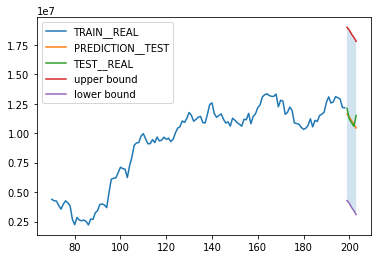

KeyboardInterrupt: 

In [11]:
# Vamos a coger una media del garch y del EWSD. Pintamos la estimacion
# con los intervalos de confianza (aproximados)
def get_file_names(folder):
    return os.listdir(folder)
names = get_file_names('LSTM\data_pred')
for i in names:
    df = pd.read_csv('LSTM\data_pred\\'+i)
    df = df.drop([df.columns[0],df.columns[3]], axis=1)
    train = df.iloc[:-5]
    test = df.iloc[-5:]
    returns = train['Actual']/(train['Actual'].max())
    train['ewm_std'] = returns.ewm(span=5).std() # 5 suele ser un hiperparámetro razonable para
                                                # pesar mas las obsv cercanas
    model = autoGarch(returns)
    forecast = model.forecast(horizon=1)
    std = ((forecast.variance.iloc[-1]**(1/2)+train['ewm_std'].iloc[-1])/2*train['Actual'].max()).iloc[0]
    plt.plot(train['Actual'][70:], label='TRAIN__REAL')
    plt.plot(test['Prediction'], label='PREDICTION__TEST')
    plt.plot(test['Actual'], label='TEST__REAL')
    plt.plot(test['Prediction']+2*std, label='upper bound')
    plt.plot(test['Prediction']-2*std, label='lower bound')
    plt.fill_between(test.index, test['Prediction']+2*std, test['Prediction']-2*std, alpha=0.2)
    plt.legend()
    plt.show()
    time.sleep(2)
    clear_output(wait=True)

In [16]:
total_std = []
# Hacemos el proceso para guardarnoslo.
for i in names:
    df = pd.read_csv('LSTM\data_pred\\'+i)
    df = df.drop([df.columns[0],df.columns[3]], axis=1)
    train = df.iloc[:-5]
    test = df.iloc[-5:]
    returns = train['Actual']/(train['Actual'].max())
    train['ewm_std'] = returns.ewm(span=5).std() # 5 suele ser un hiperparámetro razonable para
                                                # pesar mas las obsv cercanas
    model = autoGarch(returns)
    forecast = model.forecast(horizon=1)
    std = ((forecast.variance.iloc[-1]**(1/2)+train['ewm_std'].iloc[-1])/2).iloc[0]
    total_std.append(std)
    clear_output(wait=False)


In [17]:
import json
dic = {}
for i in range(len(names)):
    dic[names[i][:-4]] = total_std[i]
with open('std.json', 'w') as fp:
    json.dump(dic, fp)
